In [18]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline


In [30]:
dfs = []
for i in [1, 2, 3]:
    dfs.append(pd.read_csv(f'articles{i}.csv',
                           index_col=0,
                           parse_dates=['date', 'year', 'month'],
                           infer_datetime_format=True))

news_df = pd.concat(dfs, axis=0)

We have about 140k news articles in here.

In [32]:
news_df.shape

(142570, 9)

In [31]:
news_df.head()

,id,title,publication,author,date,year,month,url,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [53]:
# only take words with document frequencies between 2% and 80%, where words show up in that range of docs
news_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=0.02)

In [47]:
tfidf = news_vectorizer.fit_transform(news_df['content'])

In [48]:
tfidf.shape

(142570, 356)

In [10]:
dim = 500
svd = TruncatedSVD(n_components=dim)

In [11]:
lsa = svd.fit_transform(tfidf)

The sklearn docs suggest using 100 for number of dimensions, but other implementations like lsa in R use 50% of explained variance to determine number of dimensions. Looks like we could use even more than 500 topics to explain 50% of the variance.  This is probably due to the huge amount of time the news stories cover.  Let's instead take just the most recent month and restart the topic modeling analysis.

In [21]:
(svd.explained_variance_ratio_.cumsum() <= 0.5).sum()

500

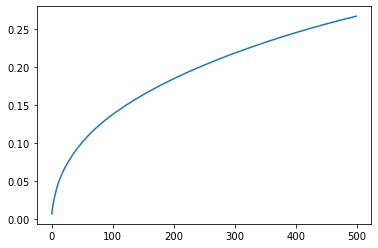

In [22]:
_ = plt.plot(svd.explained_variance_ratio_.cumsum())

# Narrowing down the data to the most recent month

Since news data changes a lot, it makes sense to narrow it down to more recent news.  We'll take the last 30 days.

In [36]:
max_date = news_df['date'].max()
max_date

Timestamp('2017-07-06 00:00:00')

In [35]:
# take news stories going back 30 days
min_date = news_df['date'].max() - pd.Timedelta('30D')
min_date

Timestamp('2017-06-06 00:00:00')

In [40]:
recent_df = news_df[(news_df['date'] > min_date) & (news_df['date'] < max_date)]
recent_df.shape

(4559, 9)

Now let's try the LSA analysis again.

In [54]:
tfidf = news_vectorizer.fit_transform(recent_df['content'])
tfidf.shape

(4559, 2619)

In [55]:
dim = 500
svd = TruncatedSVD(n_components=dim)

In [56]:
lsa = svd.fit_transform(tfidf)

In [57]:
(svd.explained_variance_ratio_.cumsum() <= 0.5).sum()

264

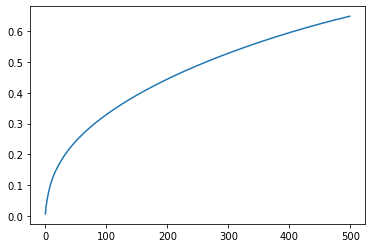

In [58]:
_ = plt.plot(svd.explained_variance_ratio_.cumsum())

We've improved a bit, but there's still lots of topics in there (~250) to explain 50% of the variance.

LSA breaks down the TFIDF matrix intro 3 matrices and is the same idea as SVD with slightly modified dimensions:

![LSA/SVD](images/LSA_SVD_Decomposition.png)
Source: https://alexisperrier.com/nlp/2015/09/16/segmentation_twitter_timelines_lda_vs_lsa.html

The matrix dimensions are:

- M: d x w, docs vs words
- U: d x t, docs vs topics
- Sigma: t x w, topics vs words
- V*: t x t, topics vs topics

If we were to transpose the tfidf matrix (tfidf.T), we would match most of the digrams shown for LSA, like this one:


![LSA](images/lsa_2.png)
Source: https://link.springer.com/chapter/10.1007/978-3-319-95663-3_6

In [82]:
# M matrix, d x w
tfidf.shape

(4559, 2619)

In [83]:
# U matrix -- d x t, documents vs topics
lsa.shape

(4559, 500)

In [87]:
# Sigma matrix -- t x t, weights/importances of topics
svd.singular_values_.shape

(500,)

In [86]:
# V* or VT matrix -- t x w, topics vs words
svd.components_.shape

(500, 2619)

So let's say we want to take the top few topics and see what they're about.  Let's stick with the top 10 topics to make it easier to understand.  We can get the indices of the top 10 topics from the V* matrix:

In [65]:
svd.singular_values_.argsort()[::-1][:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [67]:
svd.singular_values_[:20]

array([17.26434261, 10.21378074,  7.44800654,  7.11339986,  6.9019157 ,
        6.38400007,  5.99326213,  5.87278471,  5.69324802,  5.52498243,
        5.04220516,  4.90975405,  4.8380779 ,  4.71805042,  4.58910179,
        4.46051972,  4.35935285,  4.190546  ,  4.16276483,  4.14291592])

Turns out the SVD V* matrix is already ordered by topic importance, making it easier.

Next let's look at the top words in these topics.  There is definitely a better matrix-based way to do this, but I haven't figured it out, so I'm doing it row-by-row.

We can think of the values in each sigma row as the weight of that word in the topic.  So to get the top words, we get the indices of the top values.  Then we go back to our tfidfvectorizer to get the matching vocabulary.

We need to first create a dictionary of indices to vocab from our TFIDF vectorizer, though.

In [95]:
# we just reverse the dictionary of word: index to index: word
idx_vocab_dict = {i: w for w, i in news_vectorizer.vocabulary_.items()}

In [98]:
idx_vocab_dict[100]

'adding'

In [103]:
for i in range(10):
    # get a topic row with word indices as column 
    sigma_row = svd.components_[i, :]
    # sort from greatest to least
    sorted_row = sigma_row.argsort()[::-1]
    # take top 20 words and show them
    top_20_words = [idx_vocab_dict[s] for s in sorted_row[:20]]
    print(f'topic {i} top 20 words:')
    print(', '.join(top_20_words))
    print('\n\n')

topic 0 top 20 words:
trump, said, president, comey, people, house, new, says, just, investigation, like, state, time, told, police, white, government, russia, percent, fbi



topic 1 top 20 words:
comey, trump, president, fbi, investigation, russia, sessions, testimony, mueller, director, committee, flynn, intelligence, russian, justice, senate, counsel, james, obstruction, attorney



topic 2 top 20 words:
trump, percent, republicans, republican, senate, democrats, house, party, tax, medicaid, billion, obamacare, government, vote, states, election, health, obama, administration, voters



topic 3 top 20 words:
said, korea, north, police, company, qatar, comey, china, billion, percent, investigation, military, bank, attack, wednesday, officials, forces, korean, islamic, security



topic 4 top 20 words:
percent, comey, company, billion, bank, market, companies, says, amazon, inflation, million, investors, shares, financial, apple, year, foods, fbi, prices, growth



topic 5 top 20 wor

An improvement would be to take the summed TFIDF values from the words and make a wordcloud from that.

Next, let's get some sample documents from the top 10 topics.

In [110]:
for i in range(10):
    # get a row of the docs vs topics matrix, U
    u_col = lsa[:, i]
    # sort it from greatest to least values
    u_sorted = u_col.argsort()[::-1]
    print(u_col[u_sorted[:20]])
    # get the top 3 news titles from each topic
    print(f'topic {i} top 3 stories:')
    for j in range(3):
        print(recent_df.iloc[u_sorted[j]]['title'])
    
    print('\n\n')

[0.59298688 0.55783151 0.55258255 0.52659884 0.52636537 0.52594867
 0.52437349 0.52390483 0.52291598 0.52165968 0.52049108 0.51422735
 0.51404532 0.51346225 0.51309661 0.50934405 0.50400255 0.50048126
 0.49921942 0.49900408]
topic 0 top 3 stories:
Two years ago, they couldn’t look away. Now some Trump supporters are tuning out.
Trump transition goes on after weekend meeting potential appointees – live
Donald Trump rails against Chamber of Commerce – as it happened



[0.68957755 0.67463981 0.66725389 0.65766792 0.64844629 0.64337964
 0.63911056 0.63617083 0.63478886 0.62948562 0.62909322 0.62722133
 0.6212428  0.6202829  0.61987883 0.61980858 0.61679783 0.61540265
 0.61490881 0.61371605]
topic 1 top 3 stories:
Comey Accuses White House Of ’Lies, Plain And Simple’ About His Firing
7 takeaways from Comey’s extraordinary testimony about what Trump told him to do
Comey says Trump fired him to undermine FBI Russia investigation



[0.34790837 0.33806114 0.33216386 0.32579177 0.31230174 0.31

Nice, it looks like it worked!  We have a few topics about Trump, although with some subtle differences.  Same thing with North Korea.  We also have one cluster having to do with financial markets and stocks, one with the travel ban, and one with Qatar.

Combining the above two techniques would be good -- get some example titles or sentences from stories and combine them with a list or wordcloud of words from each topic.

To improve the analysis, we could stem or lemmatize the words before doing TFIDF.